<a href="https://colab.research.google.com/github/amoskwaw/Employee-Salary-Predictor/blob/main/customer_ticket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA CLEANING NOTEBOOK FOR GROUP A
This notebook contains the necessary jupiter notebook codes needed to clean the dirty customer support ticket dataset for our ML Internship week 1 project.

It basically does the following:

1. Load the necessary libraries
2. Loads and reads the dataset in a csv format
3. Performs basic EDA to check for missing data
4. Displays the top 10 and last 10 rows of the data to inspect the text.
5. Performs the needed cleaning to correct labels, remove unwanted characters, emojis, duplicates, unwanted standalone texts/numbers and deal with missing data.



## 1.  Install libraries

In [45]:
import os
import pandas as pd
import numpy as np
import re
import httpx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split


2. Load data

In [2]:
from google.colab import files
import os

# Define DATA_PATH here
DATA_PATH = "/content/drive/MyDrive/DATA_SETS/customer_support_tickets_dirty.csv"

Read Data

In [3]:
df = pd.read_csv(DATA_PATH)

print("✅ Loaded dataset.")
print("Shape:", df.shape)

✅ Loaded dataset.
Shape: (520, 4)


Exploratory Data Analysis (EDA)

In [4]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

Columns: ['text', 'label', 'ticket_id', 'agent_name']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        495 non-null    object
 1   label       495 non-null    object
 2   ticket_id   520 non-null    int64 
 3   agent_name  520 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.4+ KB
None

Missing values per column:
text          25
label         25
ticket_id      0
agent_name     0
dtype: int64


Finding Percentage of missing data

In [5]:
missing_value_percent = df.isnull().mean() * 100
print(missing_value_percent)

text          4.807692
label         4.807692
ticket_id     0.000000
agent_name    0.000000
dtype: float64


We considered replacing the missing data with "unknown" because the percentage of missing values is less than 5%

EDA- First looking at the Data

In [10]:
# Displaying first 5 rows
print("Displaying first 5 rows:")
print(df.head(5))

# Displaying last 5 rows
print("\nDisplaying last 5 rows:")
print(df.tail(5))

Displaying first 5 rows:
                                                text         label  ticket_id  \
0    Where can I find API rate limits documentation?          Othr       1000   
1                 Can I migrate data from Freshdesk?          Othr       1001   
2  Cannot update billing address; page keeps relo...       billing       1002   
3  Looking for a product roadmap or upcoming feat...         other       1003   
4              Dark mode toggled but UI stays light.  Tech-support       1004   

  agent_name  
0       Dana  
1        Bob  
2    Charlie  
3       Dana  
4      Alice  

Displaying last 5 rows:
                                                  text    label  ticket_id  \
515  Currency converted incorrectly; expected USD. ...   Billng       1515   
516          Can't verify phone number; code not sent.  ACCOUNT       1516   
517              Dark mode toggled but UI stays light.     Tech       1517   
518  Search results page is blank after entering a ...     Te

Our dataset is messy due to missing, inconsistent, unwanted information, funny characters and emojis . Cleaning it ensures that the final data is complete, consistent, and ready for accurate analysis or modeling.

Let's check for the labels in the dataset.

In [12]:
# Inspect unique labels and their counts
print("Unique labels and their counts:")
print(df['label'].value_counts())

Unique labels and their counts:
label
Accnt           42
 Tech           41
ACCOUNT         37
Othr            35
Billng          35
Billing         34
Other           33
technical       32
other           32
TECHNICAL       31
OTHER           28
billing         26
BILLING         25
 Account        22
account         21
Tech-support    21
Name: count, dtype: int64


Data cleaning

In [13]:
# Function to clean text (preserve case)
def clean_text_preserve_case(text):
    """
    Cleans text by:
    - Removing standalone '12345' and standalone 'br' words
    - Preserving case
    - Keeping digits, spaces, ., ?, @, $
    - Removing other unwanted special characters
    - Normalizing extra spaces
    """
    if not isinstance(text, str):
        return text

    # Remove standalone '12345'
    text = re.sub(r'(?<!\d)12345(?!\d)', '', text)

    # Remove standalone 'br' (case-insensitive)
    text = re.sub(r'\bbr\b', '', text, flags=re.IGNORECASE)

    # Remove unwanted characters but KEEP @ and $
    text = re.sub(r'[^A-Za-z0-9\s\.\?\@\$\-]', '', text)

    # Remove spaces before punctuation
    text = re.sub(r'\s+([.?])', r'\1', text)

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Label corrections
label_corrections = {
    'othr': 'Other',
    'tech-support': 'Technical',
    'technical-support': 'Technical',
     'TECHNICAL': 'Technical',
    'billng': 'Billing',
    'BILLING': 'Billing',
    'accnt': 'Account',
    'account': 'Account',
    'Account': 'Account',
    'other': 'Other',
    'tech': 'Technical'
}

def correct_labels(text):
    """Apply label corrections case-insensitively."""
    if not isinstance(text, str):
        return text
    cleaned = text.strip()
    for wrong, right in label_corrections.items():
        cleaned = re.sub(rf'\b{wrong}\b', right, cleaned, flags=re.IGNORECASE)
    return cleaned

#  Identify text columns
text_columns = [c for c in ['text', 'label', 'agent_name'] if c in df.columns]
if not text_columns:
    raise ValueError("None of the expected text columns ('text','label','agent_name') are present.")

#  Cleaning pipeline
df = df.drop_duplicates(keep='first')
df = df.fillna("unknown")

# Apply cleaning to text columns
for col in text_columns:
    df[col] = df[col].astype(str).apply(clean_text_preserve_case)

# Apply corrections to the label column specifically
if 'label' in df.columns:
    df['label'] = df['label'].astype(str).apply(correct_labels)

#  Diagnostics
if 'text' in df.columns:
    after_count_12345 = df['text'].astype(str).str.contains(r'\b12345\b', regex=True, na=False).sum()
    after_count_br = df['text'].astype(str).str.contains(r'\bbr\b', regex=True, na=False).sum()
    print(f"✅ '12345' occurrences removed: {after_count_12345 == 0}")
    print(f"✅ 'br' occurrences removed: {after_count_br == 0}")

#  Save cleaned file
out_path = "customer_support_tickets_clean_500.csv"
df.to_csv(out_path, index=False)
print(f"\n✅ Saved cleaned CSV to: {out_path}")
print(df.head(15).to_string(index=False))

✅ '12345' occurrences removed: True
✅ 'br' occurrences removed: True

✅ Saved cleaned CSV to: customer_support_tickets_clean_500.csv
                                                     text     label  ticket_id agent_name
          Where can I find API rate limits documentation?     Other       1000       Dana
                       Can I migrate data from Freshdesk?     Other       1001        Bob
      Cannot update billing address page keeps reloading.   Billing       1002    Charlie
      Looking for a product roadmap or upcoming features.     Other       1003       Dana
                    Dark mode toggled but UI stays light. Technical       1004      Alice
             Promo code SPRING15 not applied at checkout.   Billing       1005      Alice
   Incorrect role assigned need admin access for my team.   Account       1006       Dana
             File export to CSV generates corrupted file. Technical       1007       Dana
                  Overcharged by GHS 120 on my last bill.

recheck for missing data after cleaning

In [14]:
# Rechecking for missing data

print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

Columns: ['text', 'label', 'ticket_id', 'agent_name']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        520 non-null    object
 1   label       520 non-null    object
 2   ticket_id   520 non-null    int64 
 3   agent_name  520 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.4+ KB
None

Missing values per column:
text          0
label         0
ticket_id     0
agent_name    0
dtype: int64


*Now, there are no missing values, all noises cleaned and inconsistent labels corrected.*

*Also our clean dataset is currently saved to customer_support_tickets_clean_500.csv*

In [17]:
df.to_csv("customer_support_tickets_clean_500.csv", index=False)

# saving cleaned dataset to my local machine
from google.colab import files
files.download("customer_support_tickets_clean_500.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## VISUALIZATION

In [32]:
df.tail(20)

,text,label,ticket_id,agent_name
500,How can I request my data under GDPR?,Other,1500,Alice
501,Website returns 500 error on checkout.,Technical,1501,Charlie
502,Requesting invoice to be sent monthly instead ...,Other,1502,Charlie
503,Upload stuck at 99 for more than 10 minutes.,Technical,1503,Charlie
504,Forgot my password and reset link never arrives.,Account,1504,Bob
505,Please provide onboarding training for my team.,Other,1505,Charlie
506,Please provide onboarding training for my team.,Other,1506,Bob
507,Profile picture upload fails with unknown error.,Account,1507,Bob
508,Do you offer discounts for students or NGOs?,Other,1508,Charlie
509,When is the Pro pricing changing?,Other,1509,Bob


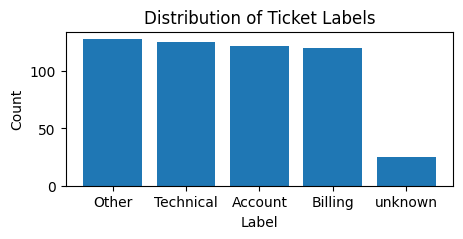

In [27]:
# Visualizing the text and label column
# Count the number of tickets for each label
label_counts = df['label'].value_counts()

# Plot a bar chart
plt.figure(figsize=(5,2))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Ticket Labels')
plt.show()

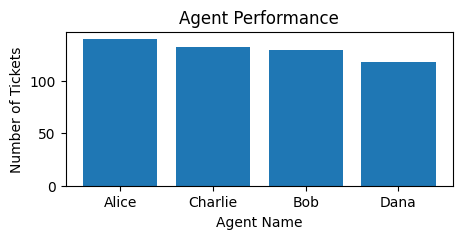

In [33]:
# Plot agent performance to show the performance of each agent in terms of the number of tickets handled
agent_name_counts = df['agent_name'].value_counts()
plt.figure(figsize=(5,2))
plt.bar(agent_name_counts.index, agent_name_counts.values)
plt.xlabel('Agent Name')
plt.ylabel('Number of Tickets')
plt.title('Agent Performance')
plt.show()

In [35]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

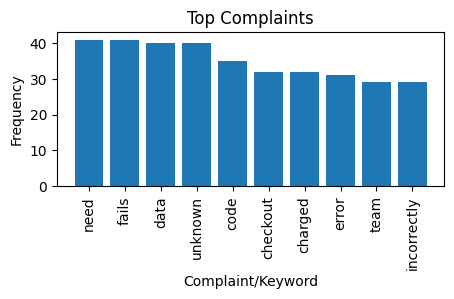

In [38]:
# Function to preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Function to preprocess text data
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = [word.lower() for word in text if word.isalpha() and word.lower() not in stop_words]
    return text

# Preprocess the text data
df['text'] = df['text'].apply(preprocess_text)

# Extract keywords/complaints
keywords = []
for text in df['text']:
    keywords.extend(text)

# Count the frequency of each keyword
keyword_counts = Counter(keywords)

# Get the top 10 most common keywords
top_keywords = keyword_counts.most_common(10)

# Separate the keywords and their frequencies
keywords, frequencies = zip(*top_keywords)

# Plot the top complaints chart
plt.figure(figsize=(5,2))
plt.bar(keywords, frequencies)
plt.xlabel('Complaint/Keyword')
plt.ylabel('Frequency')
plt.title('Top Complaints')
plt.xticks(rotation=90)
plt.show()

## **Train/test split**

In [43]:
# prepare data and split
X = df['text'].astype(str).values
y = df['label'].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
import collections
print("Train label distribution:", dict(collections.Counter(y_train)))
print("Test label distribution:", dict(collections.Counter(y_test)))


Train: 416 Test: 104
Train label distribution: {'Technical': 100, 'Account': 98, 'Other': 102, 'Billing': 96, 'unknown': 20}
Test label distribution: {'Billing': 24, 'Account': 24, 'unknown': 5, 'Technical': 25, 'Other': 26}


## Majority Classifier baseline

In [41]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib

In [48]:
# Majority classifier baseline
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
# Dummy expects 2D input, so pass reshaped arrays
dummy.fit(X_train.reshape(-1,1), y_train)
y_dummy_pred = dummy.predict(X_test.reshape(-1,1))

acc_dummy = accuracy_score(y_test, y_dummy_pred)
f1_dummy = f1_score(y_test, y_dummy_pred, average='weighted', zero_division=0)
cr_dummy = classification_report(y_test, y_dummy_pred, zero_division=0)

print("Majority Classifier — Accuracy:", acc_dummy)
print("Majority Classifier — Weighted F1:", f1_dummy)
print("\nClassification report (Majority):\n", cr_dummy)



Majority Classifier — Accuracy: 0.25
Majority Classifier — Weighted F1: 0.1

Classification report (Majority):
               precision    recall  f1-score   support

     Account       0.00      0.00      0.00        24
     Billing       0.00      0.00      0.00        24
       Other       0.25      1.00      0.40        26
   Technical       0.00      0.00      0.00        25
     unknown       0.00      0.00      0.00         5

    accuracy                           0.25       104
   macro avg       0.05      0.20      0.08       104
weighted avg       0.06      0.25      0.10       104



## TF-IDF + Logistic Regression

In [49]:
# Colab cell 6: TF-IDF vectorizer + Logistic Regression
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, y_train)
y_lr_pred = logreg.predict(X_test_tfidf)

acc_lr = accuracy_score(y_test, y_lr_pred)
f1_lr = f1_score(y_test, y_lr_pred, average='weighted', zero_division=0)
cr_lr = classification_report(y_test, y_lr_pred, zero_division=0)

print("TF-IDF + LogisticRegression — Accuracy:", acc_lr)
print("TF-IDF + LogisticRegression — Weighted F1:", f1_lr)
print("\nClassification report (TF-IDF + LR):\n", cr_lr)



TF-IDF + LogisticRegression — Accuracy: 0.9038461538461539
TF-IDF + LogisticRegression — Weighted F1: 0.8811774164522319

Classification report (TF-IDF + LR):
               precision    recall  f1-score   support

     Account       0.91      0.83      0.87        24
     Billing       0.83      1.00      0.91        24
       Other       0.93      1.00      0.96        26
   Technical       0.96      0.96      0.96        25
     unknown       0.00      0.00      0.00         5

    accuracy                           0.90       104
   macro avg       0.73      0.76      0.74       104
weighted avg       0.86      0.90      0.88       104



## Confusion matrices (visual)

In [51]:
import json
import nbformat

# plotting defaults
%matplotlib inline
plt.rcParams.update({"figure.dpi": 120})

# Create artifacts dir
os.makedirs("artifacts", exist_ok=True)
print("Artifacts directory:", os.path.abspath("artifacts"))

Artifacts directory: /content/artifacts


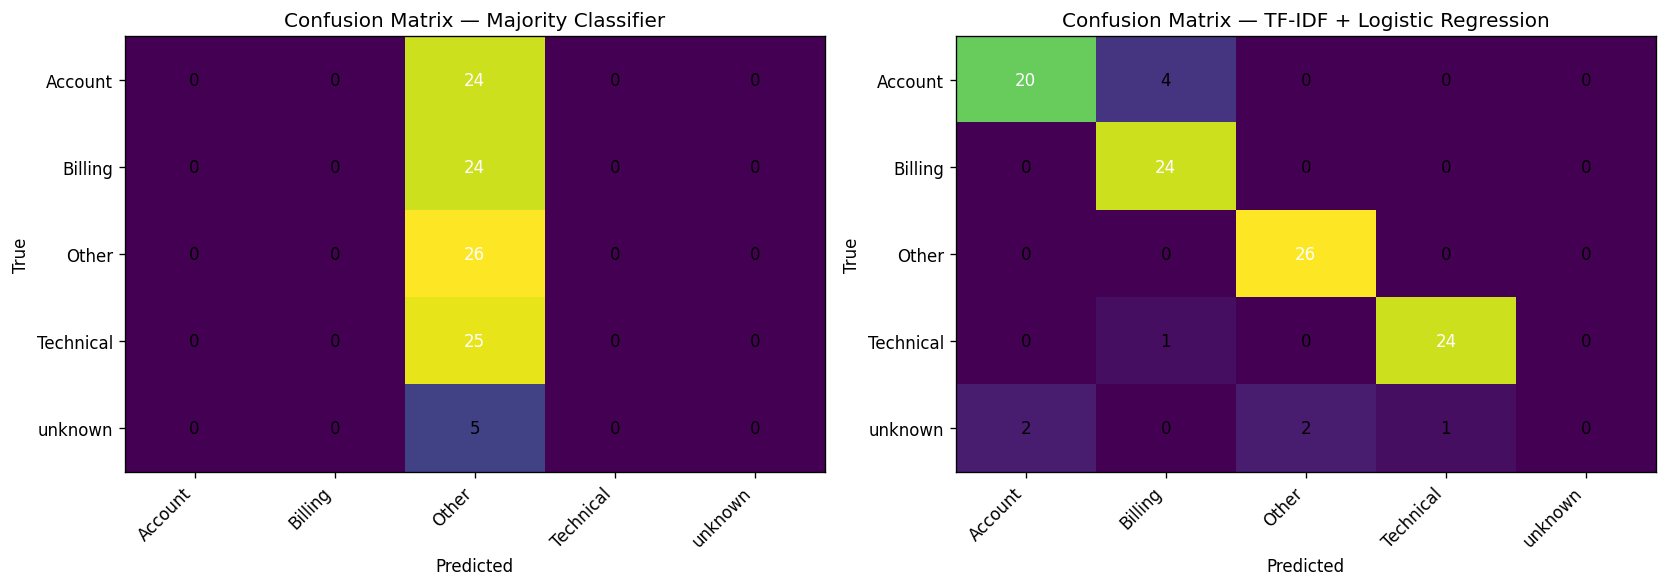

Saved confusion matrix images to artifacts/.
artifacts/confusion_matrix_majority.png
artifacts/confusion_matrix_logreg.png


In [52]:
# Colab cell 7: confusion matrices plotted and saved
labels = sorted(list(set(y)))  # alphabetical order; modify if you want custom order
cm_dummy = confusion_matrix(y_test, y_dummy_pred, labels=labels)
cm_lr    = confusion_matrix(y_test, y_lr_pred, labels=labels)

# Plot and save
fig, axes = plt.subplots(1, 2, figsize=(14,5))
im0 = axes[0].imshow(cm_dummy, interpolation='nearest', aspect='auto')
axes[0].set_title('Confusion Matrix — Majority Classifier')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
axes[0].set_xticks(range(len(labels))); axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[0].set_yticks(range(len(labels))); axes[0].set_yticklabels(labels)
for i in range(cm_dummy.shape[0]):
    for j in range(cm_dummy.shape[1]):
        axes[0].text(j, i, str(cm_dummy[i,j]), ha='center', va='center', color='white' if cm_dummy[i,j]>cm_dummy.max()/2 else 'black')

im1 = axes[1].imshow(cm_lr, interpolation='nearest', aspect='auto')
axes[1].set_title('Confusion Matrix — TF-IDF + Logistic Regression')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
axes[1].set_xticks(range(len(labels))); axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[1].set_yticks(range(len(labels))); axes[1].set_yticklabels(labels)
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        axes[1].text(j, i, str(cm_lr[i,j]), ha='center', va='center', color='white' if cm_lr[i,j]>cm_lr.max()/2 else 'black')

plt.tight_layout()
cm_dummy_path = "artifacts/confusion_matrix_majority.png"
cm_lr_path = "artifacts/confusion_matrix_logreg.png"
fig.savefig("artifacts/confusion_matrices_side_by_side.png", bbox_inches='tight')
plt.show()

# Also save each individually (optional)
plt.imsave(cm_dummy_path, cm_dummy, cmap='Blues')
plt.imsave(cm_lr_path, cm_lr, cmap='Greens')

print("Saved confusion matrix images to artifacts/.")
print(cm_dummy_path)
print(cm_lr_path)



## Save metrics JSON (artifacts/baseline_metrics.json)

In [53]:
# Colab cell 8: Save evaluation metrics and some metadata to JSON
metrics = {
    "majority": {
        "accuracy": float(acc_dummy),
        "weighted_f1": float(f1_dummy),
        "classification_report": cr_dummy
    },
    "tfidf_logreg": {
        "accuracy": float(acc_lr),
        "weighted_f1": float(f1_lr),
        "classification_report": cr_lr
    },
    "n_samples": int(len(df)),
    "train_size": int(len(X_train)),
    "test_size": int(len(X_test)),
    "labels": labels
}

metrics_path = "artifacts/baseline_metrics.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics JSON to:", metrics_path)


Saved metrics JSON to: artifacts/baseline_metrics.json


Save models (vectorizer + logistic regression)

In [54]:
# Colab cell 9: save the TF-IDF vectorizer and trained LR model
os.makedirs("artifacts/models", exist_ok=True)
vec_path = "artifacts/models/tfidf_vectorizer.joblib"
model_path = "artifacts/models/logreg_tfidf.joblib"

joblib.dump(tfidf, vec_path)
joblib.dump(logreg, model_path)

print("Saved vectorizer to:", vec_path)
print("Saved model to:", model_path)


Saved vectorizer to: artifacts/models/tfidf_vectorizer.joblib
Saved model to: artifacts/models/logreg_tfidf.joblib


### Build a Baseline Performance Report (Markdown) and save

In [61]:
# Colab cell 10: create a simple markdown report summarizing results
# Build and save the Baseline Performance Report (fixed & complete)
report_md = f"""
# Baseline Performance Report

**Dataset:** customer_support_tickets_clean_500.csv
**Total samples:** {len(df)}
**Train size:** {len(X_train)}
**Test size:** {len(X_test)}

---

## Models
### 1) Majority Classifier (most_frequent)
- Accuracy: {metrics['majority']['accuracy']:.4f}
- Weighted F1: {metrics['majority']['weighted_f1']:.4f}

### 2) TF-IDF + Logistic Regression
- Accuracy: {metrics['tfidf_logreg']['accuracy']:.4f}
- Weighted F1: {metrics['tfidf_logreg']['weighted_f1']:.4f}

---

## Classification reports

### Majority Classifier
"""

{metrics['tfidf_logreg']['classification_report']}

In [63]:

### TF-IDF + Logistic Regression


In [64]:
# Colab cell 11: create a copy of this pipeline as an .ipynb (02_baseline_models.ipynb)
nb = nbformat.v4.new_notebook()

# Prepare an ordered list of the key code cells (these strings mirror earlier cells)
cells = []

cells.append(nbformat.v4.new_markdown_cell("# Baseline models notebook\nThis notebook trains a Majority Classifier and TF-IDF + Logistic Regression, evaluates them, and saves artifacts."))
cells.append(nbformat.v4.new_code_cell("""# (1) Imports & setup

%matplotlib inline
os.makedirs('artifacts', exist_ok=True)
"""))

cells.append(nbformat.v4.new_code_cell("""# (2) Load data
csv_path = 'REPLACE_WITH_YOUR_CSV_PATH'  # change this
df = pd.read_csv(csv_path)
df = df.dropna(subset=['text','label']).reset_index(drop=True)
X = df['text'].astype(str).values
y = df['label'].astype(str).values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)
"""))

cells.append(nbformat.v4.new_code_cell("""# (3) Majority Classifier
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train.reshape(-1,1), y_train)
y_dummy_pred = dummy.predict(X_test.reshape(-1,1))
print('Accuracy:', accuracy_score(y_test, y_dummy_pred))
print('Weighted F1:', f1_score(y_test, y_dummy_pred, average='weighted', zero_division=0))
print('\\n', classification_report(y_test, y_dummy_pred, zero_division=0))
"""))

cells.append(nbformat.v4.new_code_cell("""# (4) TF-IDF + Logistic Regression
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, y_train)
y_lr_pred = logreg.predict(X_test_tfidf)
print('Accuracy:', accuracy_score(y_test, y_lr_pred))
print('Weighted F1:', f1_score(y_test, y_lr_pred, average='weighted', zero_division=0))
print('\\n', classification_report(y_test, y_lr_pred, zero_division=0))
"""))

cells.append(nbformat.v4.new_code_cell("""# (5) Save metrics (example)
metrics = {'accuracy': accuracy_score(y_test, y_lr_pred), 'weighted_f1': f1_score(y_test,y_lr_pred, average='weighted')}
with open('artifacts/baseline_metrics.json','w') as f:
    json.dump(metrics, f, indent=2)
print('Saved metrics to artifacts/baseline_metrics.json')
"""))

nb['cells'] = cells
nb_path = "02_baseline_models.ipynb"
with open(nb_path, 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)

print("Saved notebook to:", nb_path)


Saved notebook to: 02_baseline_models.ipynb


#Week 3 — Transformer Model Fine-Tuning

Install packages (run once)

In [65]:
# Colab cell 1 - install dependencies
!pip install --quiet transformers datasets evaluate accelerate scikit-learn torch torchvision nbformat

# show torch GPU availability
import torch
print("torch.__version__:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
torch.__version__: 2.8.0+cu126
CUDA available: False


In [66]:
from datasets import Dataset, DatasetDict
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding, set_seed)

# reproducibility
SEED = 42
set_seed(SEED)

# hyperparameters (change NUM_EPOCHS to 3 or 5 if you prefer)
NUM_EPOCHS = 4
MODEL_NAME = "distilbert-base-uncased"
OUTPUT_DIR = "models/distilbert-ticket-classifier"
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Artifacts directory:", ARTIFACTS_DIR)
print("Model output directory:", OUTPUT_DIR)

Artifacts directory: artifacts
Model output directory: models/distilbert-ticket-classifier


Train/test split and convert to HuggingFace Datasets

In [70]:
# Colab cell 5 - stratified split and HF Dataset

# ensure labels are strings
df['label'] = df['label'].astype(str).str.strip()

# create label2id and id2label maps
labels = sorted(df['label'].unique().tolist())
label2id = {lab: i for i, lab in enumerate(labels)}
id2label = {i: lab for lab, i in label2id.items()}

print("Labels:", labels)
print("Label2id:", label2id)

# optional: quick class counts
from collections import Counter
print("Class counts:", dict(Counter(df['label'].values)))

X = df['text'].astype(str).values
y = df['label'].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

train_df = pd.DataFrame({"text": X_train, "label": [label2id[l] for l in y_train]})
test_df  = pd.DataFrame({"text": X_test,  "label": [label2id[l] for l in y_test]})

hf_train = Dataset.from_pandas(train_df)
hf_test  = Dataset.from_pandas(test_df)

dataset_dict = DatasetDict({"train": hf_train, "test": hf_test})
print(dataset_dict)


Labels: ['Account', 'Billing', 'Other', 'Technical', 'unknown']
Label2id: {'Account': 0, 'Billing': 1, 'Other': 2, 'Technical': 3, 'unknown': 4}
Class counts: {'Other': 128, 'Billing': 120, 'Technical': 125, 'Account': 122, 'unknown': 25}
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 416
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
})


Tokenization

In [71]:
# Colab cell 6 - tokenizer and tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=128)

# tokenize datasets (batched)
tokenized_datasets = dataset_dict.map(preprocess, batched=True, remove_columns=["text"])
# set format to PyTorch tensors later via Trainer automatically when using DataCollator
print(tokenized_datasets)


Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 416
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 104
    })
})


Data collator and model init

In [72]:
# Colab cell 7 - data collator and model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label={str(k): v for k, v in id2label.items()},  # optional mapping (strings)
    label2id={v: k for k, v in label2id.items()}
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define compute_metrics and TrainingArguments

In [81]:
# Colab cell 8 - metrics and training args
import evaluate

# We'll compute accuracy and weighted F1
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    w_f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {"accuracy": acc, "weighted_f1": w_f1}

# Training arguments - adjust batch sizes if GPU memory is limited
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # reduce to 8 if OOM
    per_device_eval_batch_size=32,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="weighted_f1",
    greater_is_better=True,
    logging_dir=os.path.join(ARTIFACTS_DIR, "logs"),
    logging_strategy="steps",
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  # use fp16 if GPU available
) # Removed the extra comma here

print(training_args)

TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

Create Trainer and train

In [79]:
!pip install transformers --upgrade

In [ ]:
# Colab cell 9 - trainer creation and training
from transformers import Trainer

# Define compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    w_f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "weighted_f1": w_f1}

# Create Trainer instance
from transformers import Trainer

# Define compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    w_f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "weighted_f1": w_f1}

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
train_result = trainer.train()
trainer.save_model(OUTPUT_DIR)  # saves model + tokenizer config
tokenizer.save_pretrained(OUTPUT_DIR)
print("Model & tokenizer saved to:", OUTPUT_DIR)

# Save training metrics
train_metrics = train_result.metrics
train_metrics_path = os.path.join(ARTIFACTS_DIR, "train_metrics.json")
with open(train_metrics_path, "w") as f:
    json.dump(train_metrics, f, indent=2)
print("Saved training metrics to:", train_metrics_path)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: